# Bitcoin Time Series Prediction with LSTM
[Source link](https://www.kaggle.com/code/msranjanarajputcse/bitcoin-time-series-prediction-with-lstm)

## Importing the libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the dataset

In [36]:
data = pd.read_csv("data/bitcoin_price.csv", index_col="Date", parse_dates=["Date"])
data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-07-31,2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [37]:
start_date = data.index.min()
start_date = start_date.strftime(format="%Y-%m-%d")

end_date = data.index.max()
end_date = end_date.strftime(format="%Y-%m-%d")
print(f"The dataset is between {start_date!r} and {end_date!r}")

The dataset is between '2013-04-28' and '2017-07-31'


### Viewing data info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1556 entries, 2017-07-31 to 2013-04-28
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1556 non-null   float64
 1   High        1556 non-null   float64
 2   Low         1556 non-null   float64
 3   Close       1556 non-null   float64
 4   Volume      1556 non-null   object 
 5   Market Cap  1556 non-null   object 
dtypes: float64(4), object(2)
memory usage: 85.1+ KB


### Describing data

In [5]:
data.describe()

,Open,High,Low,Close
count,1556.000000,1556.000000,1556.000000,1556.000000
mean,582.625328,597.992847,567.851446,584.239396
std,523.137312,542.992855,505.877401,525.904442
min,68.500000,74.560000,65.530000,68.430000
25%,254.287500,260.327500,248.835000,254.320000
50%,438.600000,447.560000,430.570000,438.855000
75%,662.437500,674.525000,646.735000,663.402500
max,2953.220000,2999.910000,2840.530000,2958.110000


## Plotting the Bitcoin opening price

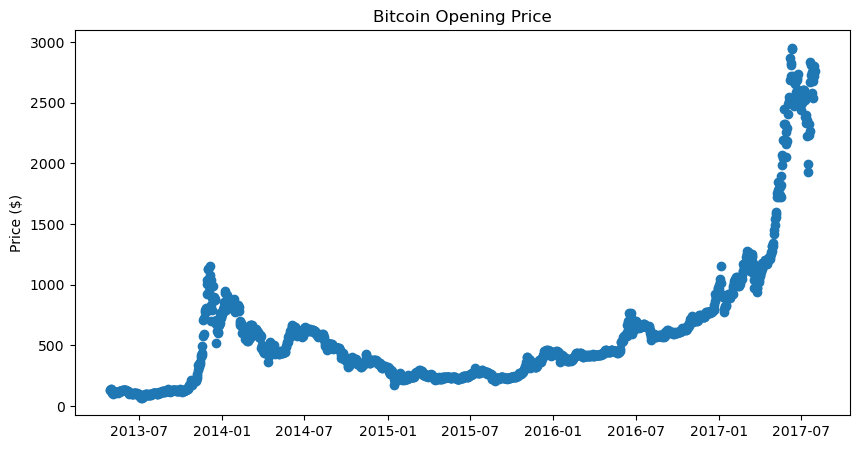

In [6]:
plt.figure(figsize=(10, 5))
plt.scatter(x=data.index, y=data["Open"])
plt.title("Bitcoin Opening Price")
plt.ylabel("Price ($)");

## Using **Open** price as a feature to train the LSTM model

In [7]:
values = data["Open"].values.reshape(-1, 1)
values = values.astype("float32")

print(f"Values {values.shape}")
print(values[:5, :])

Values (1556, 1)
[[2763.24]
 [2724.39]
 [2807.02]
 [2679.73]
 [2538.71]]


## Scaling the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled[:5, :])

[[0.9341427 ]
 [0.92067516]
 [0.9493191 ]
 [0.90519357]
 [0.85630834]]


## Splitting the data to training and testing

In [9]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size, :], scaled[train_size:len(scaled), :]
print(f"train {train.shape}")
print(f"test  {test.shape}")

train (1089, 1)
test  (467, 1)


#### Create function for creating dataset with look back

In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Generate dataset for X_train, y_train, X_test, y_test

In [11]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(f"X_train {X_train.shape}")
print(f"X_test {X_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_test {y_test.shape}")

X_train (1088, 1)
X_test (466, 1)
y_train (1088,)
y_test (466,)


### Reshaping X_train and X_test for model training

In [12]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"X_train {X_train.shape}")
print(f"X_test {X_test.shape}")

X_train (1088, 1, 1)
X_test (466, 1, 1)


## Creating the LSTM model

In [13]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## Compiling and running the model

In [14]:
model.compile(loss="mae", optimizer="adam")

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=100,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False,
)

Epoch 1/200
11/11 [==============================] - 3s 85ms/step - loss: 0.1873 - val_loss: 0.0993
Epoch 2/200
11/11 [==============================] - 0s 25ms/step - loss: 0.1423 - val_loss: 0.0886
Epoch 3/200
11/11 [==============================] - 0s 30ms/step - loss: 0.1240 - val_loss: 0.0815
Epoch 4/200
11/11 [==============================] - 0s 27ms/step - loss: 0.1145 - val_loss: 0.0783
Epoch 5/200
11/11 [==============================] - 0s 24ms/step - loss: 0.1096 - val_loss: 0.0764
Epoch 6/200
11/11 [==============================] - 0s 25ms/step - loss: 0.1057 - val_loss: 0.0746
Epoch 7/200
11/11 [==============================] - 0s 23ms/step - loss: 0.1029 - val_loss: 0.0730
Epoch 8/200
11/11 [==============================] - 0s 30ms/step - loss: 0.1006 - val_loss: 0.0712
Epoch 9/200
11/11 [==============================] - 0s 26ms/step - loss: 0.0981 - val_loss: 0.0692
Epoch 10/200
11/11 [==============================] - 0s 29ms/step - loss: 0.0955 - val_loss: 0.0671

### Plotting loss vs epoch

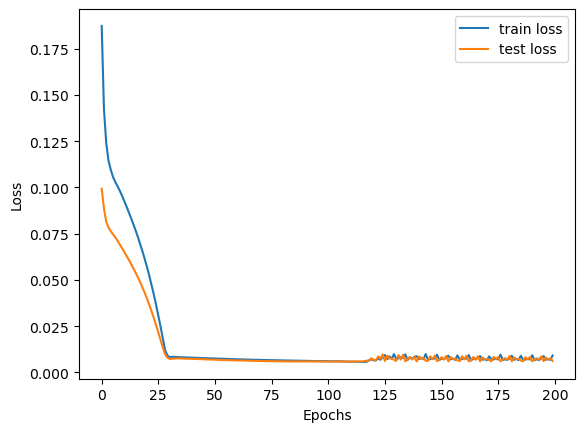

In [15]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Make prediction using X_text and plotting line graph against y_test

15/15 [==============================] - 1s 4ms/step


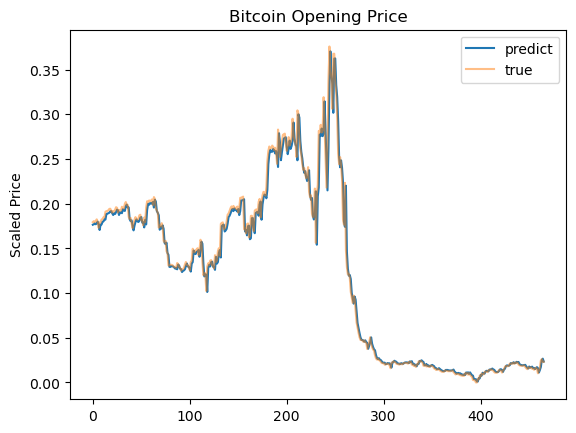

In [16]:
y_pred = model.predict(X_test)
plt.plot(y_pred, label="predict")
plt.plot(y_test, label="true", alpha=0.5)
plt.title("Bitcoin Opening Price")
plt.ylabel("Scaled Price")
plt.legend()
plt.show();

### Scaler Inverse y_perd and y_test back to normal value

In [17]:
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

#### RMSE

In [18]:
from sklearn.metrics import mean_squared_error

rmse = (mean_squared_error(y_test_inverse, y_pred_inverse)) ** 0.5
print(f"Test RMSE: {rmse:.3f}")

Test RMSE: 35.017


### Plotting predicted and actual

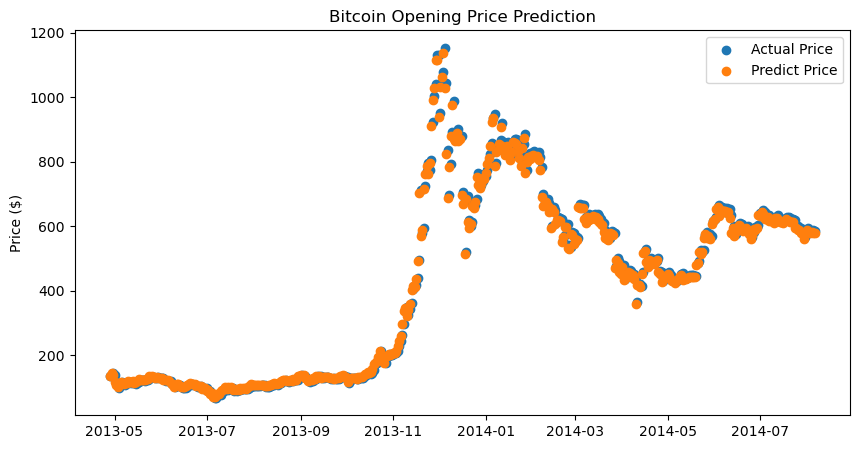

In [19]:
predict_dates = data.tail(len(X_test)).index
plt.figure(figsize=(10, 5))
plt.scatter(x=predict_dates, y=y_test_inverse, label="Actual Price")
plt.scatter(x=predict_dates, y=y_pred_inverse, label="Predict Price")
plt.title("Bitcoin Opening Price Prediction")
plt.ylabel("Price ($)");
plt.legend();